# **DEEP LEARNING**

**UNIVERSIDAD MILITAR NUEVA GRANADA**

**MODELO DE CLASIFICACIÓN DE IMÁGENES CON MLP**

Facultad de Ingeniería

Presentado por: José Torres 1401499 - Fiorella Trujillo 1401519

In [1]:
# ======================================
# 1. Instalación y carga del dataset
# ======================================
!pip install medmnist torch torchvision optuna

import medmnist
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
import numpy as np

# Dataset PathMNIST → 9 clases, RGB
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_classes = len(info['label'])
num_channels = info['n_channels']   # RGB = 3 canales

print(f"Dataset: {data_flag}, Tarea: {task}, Nº clases: {n_classes}, Canales: {num_channels}")

# Transformaciones
if num_channels == 3:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

# Cargar datasets
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=transform, download=download)
val_dataset   = DataClass(split='val', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.7 MB/s eta 0:00:00
Dataset: pathmnist, Tarea: multi-class, Nº clases: 9, Canales: 3


100%|██████████| 206M/206M [00:15<00:00, 13.6MB/s]


**Paso 1: Modelo implementado**

In [2]:
# ======================================
# 2. Modelo MLP
# ======================================
class SimpleMLP(nn.Module):
    def __init__(self, num_channels=3, num_classes=9, hidden_dim=256):
        super(SimpleMLP, self).__init__()
        input_dim = num_channels * 28 * 28
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# ======================================
# 3. Función de entrenamiento y validación
# ======================================
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

    for epoch in range(epochs):
        # ---- Entrenamiento ----
        model.train()
        total, correct, running_loss = 0, 0, 0
        for images, labels in train_loader:
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct/total
        train_loss = running_loss/len(train_loader)

        # ---- Validación ----
        model.eval()
        total, correct, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.squeeze().long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct/total
        val_loss /= len(val_loader)

        # Guardar métricas
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        #Imprimir en formato pedido
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, "
              f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list, val_acc_list[-1]

**Paso 2: Selección y ajuste de modelo**

In [4]:
# ======================================
# 4. Objetivo de Optuna
# ======================================
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 64, 512, step=64)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Nuevos dataloaders con batch_size sugerido
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleMLP(num_channels=num_channels, num_classes=n_classes, hidden_dim=hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, lr={lr:.5f}, batch_size={batch_size}")
    _, _, _, _, val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10) #Epocas cada Intento

    return val_acc  # optimizamos validación

In [5]:
# ======================================
# 5. Ejecutar búsqueda Optuna
# ======================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  #Cambia n_trials para más intentos


[I 2025-08-26 00:41:01,212] A new study created in memory with name: no-name-b27acc8f-5b9d-4569-bb01-3394d44ea48f
/tmp/ipython-input-2468375839.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Trial 0: hidden_dim=512, lr=0.00201, batch_size=256
Epoch 1/10 | Train Acc: 0.455, Val Acc: 0.526, Train Loss: 1.463, Val Loss: 1.280
Epoch 2/10 | Train Acc: 0.543, Val Acc: 0.554, Train Loss: 1.236, Val Loss: 1.235
Epoch 3/10 | Train Acc: 0.561, Val Acc: 0.536, Train Loss: 1.183, Val Loss: 1.237
Epoch 4/10 | Train Acc: 0.574, Val Acc: 0.557, Train Loss: 1.146, Val Loss: 1.197
Epoch 5/10 | Train Acc: 0.587, Val Acc: 0.574, Train Loss: 1.114, Val Loss: 1.151
Epoch 6/10 | Train Acc: 0.600, Val Acc: 0.568, Train Loss: 1.076, Val Loss: 1.146
Epoch 7/10 | Train Acc: 0.615, Val Acc: 0.599, Train Loss: 1.037, Val Loss: 1.090
Epoch 8/10 | Train Acc: 0.625, Val Acc: 0.596, Train Loss: 1.010, Val Loss: 1.113
Epoch 9/10 | Train Acc: 0.635, Val Acc: 0.607, Train Loss: 0.980, Val Loss: 1.082


[I 2025-08-26 00:45:25,438] Trial 0 finished with value: 0.6110555777688924 and parameters: {'hidden_dim': 512, 'lr': 0.00200996709061464, 'batch_size': 256}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.644, Val Acc: 0.611, Train Loss: 0.957, Val Loss: 1.078
Trial 1: hidden_dim=256, lr=0.00036, batch_size=128
Epoch 1/10 | Train Acc: 0.444, Val Acc: 0.509, Train Loss: 1.488, Val Loss: 1.320
Epoch 2/10 | Train Acc: 0.539, Val Acc: 0.546, Train Loss: 1.254, Val Loss: 1.260
Epoch 3/10 | Train Acc: 0.562, Val Acc: 0.565, Train Loss: 1.193, Val Loss: 1.193
Epoch 4/10 | Train Acc: 0.575, Val Acc: 0.578, Train Loss: 1.151, Val Loss: 1.171
Epoch 5/10 | Train Acc: 0.587, Val Acc: 0.561, Train Loss: 1.116, Val Loss: 1.182
Epoch 6/10 | Train Acc: 0.599, Val Acc: 0.577, Train Loss: 1.085, Val Loss: 1.144
Epoch 7/10 | Train Acc: 0.612, Val Acc: 0.589, Train Loss: 1.053, Val Loss: 1.116
Epoch 8/10 | Train Acc: 0.622, Val Acc: 0.595, Train Loss: 1.022, Val Loss: 1.108
Epoch 9/10 | Train Acc: 0.633, Val Acc: 0.587, Train Loss: 0.991, Val Loss: 1.119


[I 2025-08-26 00:49:14,998] Trial 1 finished with value: 0.6076569372251099 and parameters: {'hidden_dim': 256, 'lr': 0.0003612676875509551, 'batch_size': 128}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.645, Val Acc: 0.608, Train Loss: 0.964, Val Loss: 1.060
Trial 2: hidden_dim=64, lr=0.00583, batch_size=128
Epoch 1/10 | Train Acc: 0.440, Val Acc: 0.475, Train Loss: 1.487, Val Loss: 1.389
Epoch 2/10 | Train Acc: 0.509, Val Acc: 0.501, Train Loss: 1.323, Val Loss: 1.349
Epoch 3/10 | Train Acc: 0.526, Val Acc: 0.472, Train Loss: 1.269, Val Loss: 1.447
Epoch 4/10 | Train Acc: 0.538, Val Acc: 0.527, Train Loss: 1.239, Val Loss: 1.255
Epoch 5/10 | Train Acc: 0.554, Val Acc: 0.540, Train Loss: 1.202, Val Loss: 1.244
Epoch 6/10 | Train Acc: 0.560, Val Acc: 0.528, Train Loss: 1.180, Val Loss: 1.299
Epoch 7/10 | Train Acc: 0.562, Val Acc: 0.525, Train Loss: 1.170, Val Loss: 1.298
Epoch 8/10 | Train Acc: 0.567, Val Acc: 0.545, Train Loss: 1.150, Val Loss: 1.227
Epoch 9/10 | Train Acc: 0.574, Val Acc: 0.549, Train Loss: 1.131, Val Loss: 1.164


[I 2025-08-26 00:52:30,746] Trial 2 finished with value: 0.5781687325069972 and parameters: {'hidden_dim': 64, 'lr': 0.005827413412137103, 'batch_size': 128}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.581, Val Acc: 0.578, Train Loss: 1.114, Val Loss: 1.131
Trial 3: hidden_dim=192, lr=0.00013, batch_size=256
Epoch 1/10 | Train Acc: 0.376, Val Acc: 0.434, Train Loss: 1.650, Val Loss: 1.566
Epoch 2/10 | Train Acc: 0.465, Val Acc: 0.475, Train Loss: 1.494, Val Loss: 1.452
Epoch 3/10 | Train Acc: 0.503, Val Acc: 0.501, Train Loss: 1.381, Val Loss: 1.356
Epoch 4/10 | Train Acc: 0.524, Val Acc: 0.527, Train Loss: 1.304, Val Loss: 1.310
Epoch 5/10 | Train Acc: 0.540, Val Acc: 0.535, Train Loss: 1.256, Val Loss: 1.265
Epoch 6/10 | Train Acc: 0.556, Val Acc: 0.554, Train Loss: 1.221, Val Loss: 1.239
Epoch 7/10 | Train Acc: 0.566, Val Acc: 0.556, Train Loss: 1.197, Val Loss: 1.223
Epoch 8/10 | Train Acc: 0.574, Val Acc: 0.551, Train Loss: 1.175, Val Loss: 1.210
Epoch 9/10 | Train Acc: 0.580, Val Acc: 0.569, Train Loss: 1.156, Val Loss: 1.189


[I 2025-08-26 00:56:00,551] Trial 3 finished with value: 0.5768692522990804 and parameters: {'hidden_dim': 192, 'lr': 0.0001252531121173757, 'batch_size': 256}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.586, Val Acc: 0.577, Train Loss: 1.140, Val Loss: 1.179
Trial 4: hidden_dim=448, lr=0.00412, batch_size=256
Epoch 1/10 | Train Acc: 0.436, Val Acc: 0.504, Train Loss: 1.566, Val Loss: 1.342
Epoch 2/10 | Train Acc: 0.530, Val Acc: 0.536, Train Loss: 1.277, Val Loss: 1.252
Epoch 3/10 | Train Acc: 0.549, Val Acc: 0.533, Train Loss: 1.222, Val Loss: 1.265
Epoch 4/10 | Train Acc: 0.559, Val Acc: 0.551, Train Loss: 1.186, Val Loss: 1.223
Epoch 5/10 | Train Acc: 0.570, Val Acc: 0.522, Train Loss: 1.151, Val Loss: 1.292
Epoch 6/10 | Train Acc: 0.579, Val Acc: 0.553, Train Loss: 1.131, Val Loss: 1.200
Epoch 7/10 | Train Acc: 0.587, Val Acc: 0.574, Train Loss: 1.104, Val Loss: 1.160
Epoch 8/10 | Train Acc: 0.595, Val Acc: 0.575, Train Loss: 1.079, Val Loss: 1.147
Epoch 9/10 | Train Acc: 0.604, Val Acc: 0.581, Train Loss: 1.055, Val Loss: 1.143


[I 2025-08-26 01:00:16,540] Trial 4 finished with value: 0.5792682926829268 and parameters: {'hidden_dim': 448, 'lr': 0.004118475692936868, 'batch_size': 256}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.611, Val Acc: 0.579, Train Loss: 1.038, Val Loss: 1.118
Trial 5: hidden_dim=448, lr=0.00466, batch_size=256
Epoch 1/10 | Train Acc: 0.442, Val Acc: 0.511, Train Loss: 1.557, Val Loss: 1.305
Epoch 2/10 | Train Acc: 0.533, Val Acc: 0.550, Train Loss: 1.274, Val Loss: 1.244
Epoch 3/10 | Train Acc: 0.550, Val Acc: 0.547, Train Loss: 1.225, Val Loss: 1.235
Epoch 4/10 | Train Acc: 0.558, Val Acc: 0.543, Train Loss: 1.192, Val Loss: 1.239
Epoch 5/10 | Train Acc: 0.568, Val Acc: 0.565, Train Loss: 1.160, Val Loss: 1.192
Epoch 6/10 | Train Acc: 0.574, Val Acc: 0.539, Train Loss: 1.137, Val Loss: 1.232
Epoch 7/10 | Train Acc: 0.579, Val Acc: 0.552, Train Loss: 1.126, Val Loss: 1.180
Epoch 8/10 | Train Acc: 0.589, Val Acc: 0.576, Train Loss: 1.099, Val Loss: 1.150
Epoch 9/10 | Train Acc: 0.597, Val Acc: 0.574, Train Loss: 1.075, Val Loss: 1.127


[I 2025-08-26 01:04:41,508] Trial 5 finished with value: 0.5585765693722511 and parameters: {'hidden_dim': 448, 'lr': 0.004664149409998041, 'batch_size': 256}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.604, Val Acc: 0.559, Train Loss: 1.056, Val Loss: 1.154
Trial 6: hidden_dim=128, lr=0.00022, batch_size=64
Epoch 1/10 | Train Acc: 0.433, Val Acc: 0.501, Train Loss: 1.527, Val Loss: 1.371
Epoch 2/10 | Train Acc: 0.524, Val Acc: 0.529, Train Loss: 1.292, Val Loss: 1.262
Epoch 3/10 | Train Acc: 0.553, Val Acc: 0.553, Train Loss: 1.213, Val Loss: 1.231
Epoch 4/10 | Train Acc: 0.569, Val Acc: 0.569, Train Loss: 1.173, Val Loss: 1.196
Epoch 5/10 | Train Acc: 0.580, Val Acc: 0.565, Train Loss: 1.142, Val Loss: 1.183
Epoch 6/10 | Train Acc: 0.587, Val Acc: 0.579, Train Loss: 1.117, Val Loss: 1.155
Epoch 7/10 | Train Acc: 0.596, Val Acc: 0.581, Train Loss: 1.091, Val Loss: 1.144
Epoch 8/10 | Train Acc: 0.605, Val Acc: 0.580, Train Loss: 1.068, Val Loss: 1.131
Epoch 9/10 | Train Acc: 0.615, Val Acc: 0.591, Train Loss: 1.045, Val Loss: 1.112


[I 2025-08-26 01:08:33,162] Trial 6 finished with value: 0.5942622950819673 and parameters: {'hidden_dim': 128, 'lr': 0.00021783036356649003, 'batch_size': 64}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.622, Val Acc: 0.594, Train Loss: 1.024, Val Loss: 1.099
Trial 7: hidden_dim=256, lr=0.00389, batch_size=256
Epoch 1/10 | Train Acc: 0.441, Val Acc: 0.521, Train Loss: 1.527, Val Loss: 1.320
Epoch 2/10 | Train Acc: 0.528, Val Acc: 0.528, Train Loss: 1.273, Val Loss: 1.286
Epoch 3/10 | Train Acc: 0.549, Val Acc: 0.551, Train Loss: 1.219, Val Loss: 1.227
Epoch 4/10 | Train Acc: 0.558, Val Acc: 0.559, Train Loss: 1.190, Val Loss: 1.207
Epoch 5/10 | Train Acc: 0.566, Val Acc: 0.568, Train Loss: 1.169, Val Loss: 1.200
Epoch 6/10 | Train Acc: 0.576, Val Acc: 0.562, Train Loss: 1.144, Val Loss: 1.183
Epoch 7/10 | Train Acc: 0.582, Val Acc: 0.569, Train Loss: 1.119, Val Loss: 1.176
Epoch 8/10 | Train Acc: 0.587, Val Acc: 0.555, Train Loss: 1.106, Val Loss: 1.197
Epoch 9/10 | Train Acc: 0.597, Val Acc: 0.581, Train Loss: 1.083, Val Loss: 1.142


[I 2025-08-26 01:12:12,560] Trial 7 finished with value: 0.5738704518192723 and parameters: {'hidden_dim': 256, 'lr': 0.003892585170092507, 'batch_size': 256}. Best is trial 0 with value: 0.6110555777688924.


Epoch 10/10 | Train Acc: 0.601, Val Acc: 0.574, Train Loss: 1.071, Val Loss: 1.155
Trial 8: hidden_dim=512, lr=0.00031, batch_size=128
Epoch 1/10 | Train Acc: 0.454, Val Acc: 0.519, Train Loss: 1.464, Val Loss: 1.288
Epoch 2/10 | Train Acc: 0.547, Val Acc: 0.554, Train Loss: 1.230, Val Loss: 1.213
Epoch 3/10 | Train Acc: 0.570, Val Acc: 0.571, Train Loss: 1.167, Val Loss: 1.176
Epoch 4/10 | Train Acc: 0.586, Val Acc: 0.576, Train Loss: 1.124, Val Loss: 1.166
Epoch 5/10 | Train Acc: 0.600, Val Acc: 0.582, Train Loss: 1.080, Val Loss: 1.135
Epoch 6/10 | Train Acc: 0.614, Val Acc: 0.597, Train Loss: 1.043, Val Loss: 1.110
Epoch 7/10 | Train Acc: 0.629, Val Acc: 0.593, Train Loss: 1.007, Val Loss: 1.102
Epoch 8/10 | Train Acc: 0.642, Val Acc: 0.576, Train Loss: 0.972, Val Loss: 1.144
Epoch 9/10 | Train Acc: 0.656, Val Acc: 0.618, Train Loss: 0.936, Val Loss: 1.046


[I 2025-08-26 01:17:26,227] Trial 8 finished with value: 0.6211515393842463 and parameters: {'hidden_dim': 512, 'lr': 0.00030963496104920445, 'batch_size': 128}. Best is trial 8 with value: 0.6211515393842463.


Epoch 10/10 | Train Acc: 0.668, Val Acc: 0.621, Train Loss: 0.900, Val Loss: 1.030
Trial 9: hidden_dim=256, lr=0.00099, batch_size=64
Epoch 1/10 | Train Acc: 0.478, Val Acc: 0.536, Train Loss: 1.399, Val Loss: 1.241
Epoch 2/10 | Train Acc: 0.548, Val Acc: 0.552, Train Loss: 1.222, Val Loss: 1.233
Epoch 3/10 | Train Acc: 0.565, Val Acc: 0.567, Train Loss: 1.170, Val Loss: 1.184
Epoch 4/10 | Train Acc: 0.582, Val Acc: 0.556, Train Loss: 1.124, Val Loss: 1.208
Epoch 5/10 | Train Acc: 0.598, Val Acc: 0.577, Train Loss: 1.082, Val Loss: 1.158
Epoch 6/10 | Train Acc: 0.613, Val Acc: 0.590, Train Loss: 1.044, Val Loss: 1.111
Epoch 7/10 | Train Acc: 0.624, Val Acc: 0.590, Train Loss: 1.005, Val Loss: 1.103
Epoch 8/10 | Train Acc: 0.637, Val Acc: 0.608, Train Loss: 0.972, Val Loss: 1.072
Epoch 9/10 | Train Acc: 0.645, Val Acc: 0.605, Train Loss: 0.944, Val Loss: 1.083


[I 2025-08-26 01:21:56,894] Trial 9 finished with value: 0.6029588164734107 and parameters: {'hidden_dim': 256, 'lr': 0.0009864084545522058, 'batch_size': 64}. Best is trial 8 with value: 0.6211515393842463.


Epoch 10/10 | Train Acc: 0.655, Val Acc: 0.603, Train Loss: 0.920, Val Loss: 1.059


Epoch 1/10 | Train Acc: 0.454, Val Acc: 0.506, Train Loss: 1.460, Val Loss: 1.305
Epoch 2/10 | Train Acc: 0.544, Val Acc: 0.548, Train Loss: 1.236, Val Loss: 1.241
Epoch 3/10 | Train Acc: 0.569, Val Acc: 0.562, Train Loss: 1.172, Val Loss: 1.192
Epoch 4/10 | Train Acc: 0.585, Val Acc: 0.574, Train Loss: 1.124, Val Loss: 1.168
Epoch 5/10 | Train Acc: 0.600, Val Acc: 0.550, Train Loss: 1.086, Val Loss: 1.185
Epoch 6/10 | Train Acc: 0.612, Val Acc: 0.594, Train Loss: 1.048, Val Loss: 1.111
Epoch 7/10 | Train Acc: 0.628, Val Acc: 0.599, Train Loss: 1.010, Val Loss: 1.095
Epoch 8/10 | Train Acc: 0.640, Val Acc: 0.612, Train Loss: 0.976, Val Loss: 1.064
Epoch 9/10 | Train Acc: 0.652, Val Acc: 0.612, Train Loss: 0.942, Val Loss: 1.057
Epoch 10/10 | Train Acc: 0.666, Val Acc: 0.604, Train Loss: 0.906, Val Loss: 1.060


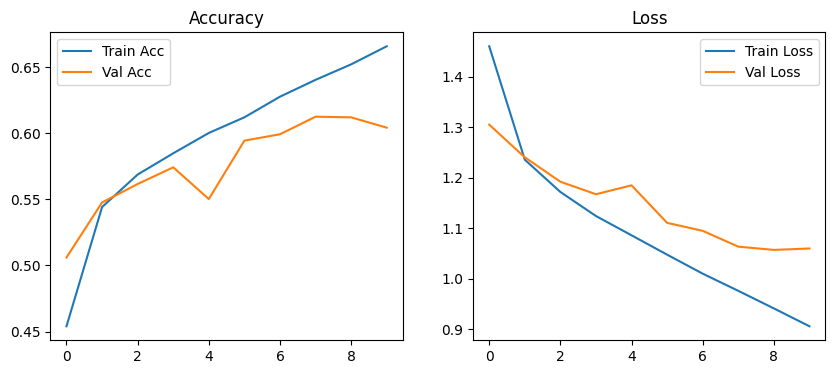

In [6]:
# ======================================
# 6. Entrenar con los mejores hiperparámetros y graficar
# ======================================
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

model = SimpleMLP(num_channels=num_channels, num_classes=n_classes, hidden_dim=best_params["hidden_dim"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

train_acc, val_acc, train_loss, val_loss, _ = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10)

# Gráficas finales
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()